## 01- Cluster interpretation
- This notebook uses the input variables for LCA to predict cluster assignments with a decision tree. Using results from the decision tree, we can interpret the meaning of each cluster

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Common imports
import os
import sys
import re
from pathlib import Path

# sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

# Performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score
from sklearn.model_selection import train_test_split

# to save the model
import joblib

In [2]:
sys.path.append('../')
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# reload modules so any new changes gets loaded
%autoreload 2
from tb_analysis.config.core import config, PACKAGE_ROOT, DATA_DIR, IMAGES_DIR, TRAINED_MODEL_DIR
from tb_analysis import preprocessors as pp, train as tr, rule_generation as cr, evaluate as ev
from tb_analysis import __version__ as _version

### Get version number

In [3]:
with open(PACKAGE_ROOT / "VERSION") as version_file:
    __version__ = version_file.read().strip()

## Import data

In [4]:
raw = pd.read_csv(Path(f"{DATA_DIR}/{config.app_config.data_file}"))

# rows and columns of the data
print(raw.shape)

# visualise the dataset
raw.head()

(204, 802)


,startscreen,endscreen,todayscreen,P_ID,Q2screen,Q3screen,Q4screen,Q5screen,Q6screen,Q7screen,...,flwMissdsg1_3,GPT1_3,refl_remind1_3,featurerating1,featurerating2,featurerating3,feature_ratenw,pouch_usablity,merm_usablity,owned_mobile
0,18-Oct-21,18-Oct-21,18-Oct-21,18859298,36,Male,2,Informal sector salaried,Till primary,20000,...,1,1,1,4.760000e-14,1.0,1.370000e-13,2,1,1,1
1,19-Oct-21,19-Oct-21,19-Oct-21,20256106,40,Female,3,Unemployed (voluntary or involuntary unemploym...,Till primary,17000,...,1,1,1,4.760000e-14,1.0,1.370000e-13,2,1,1,1
2,22-Oct-21,22-Oct-21,22-Oct-21,18958957,24,Male,3,Formal sector salaried (fixed salary from an o...,Till graduation,10000,...,1,1,1,4.760000e-14,1.0,1.370000e-13,2,1,0,1
3,11-Oct-21,11-Oct-21,11-Oct-21,20697295,20,1,19,5,4,25000,...,1,1,1,4.760000e-14,1.0,1.370000e-13,2,1,1,1
4,19-Oct-21,19-Oct-21,19-Oct-21,17049522,34,Female,3,Daily wage (employed and compensated independe...,Till secondary,10000,...,1,1,1,4.760000e-14,1.0,1.370000e-13,2,1,1,1


## Get data subset
- Only get columns that are in the data dictionary
- Discrad all columns with "raw variable names", except for P_ID (unique identifier)

In [5]:
# Read data dictionary
data_dict = pd.read_csv(Path(f"{DATA_DIR}/{config.app_config.dict_file}"),encoding='latin-1')

In [6]:
# Get Var Name column
vars_to_keep = data_dict['Var Name'].tolist()

In [7]:
# Only 122 variables in the data dictionary were considered for clustering
# A subset of the 800 variables from the instrument were considered for profiling the cluster (in notebook # 2)
data = raw.filter(items=vars_to_keep)

## Distribution of classes for each prototype
- For each prototype, we did the following:
    - Using LCA (in STATA), observations were clustered into 3 classes using binarized user rating on the prototype's features (e.g., size of pouch)
- Plot the proportion of observations in each of the 3 classes in each prototype

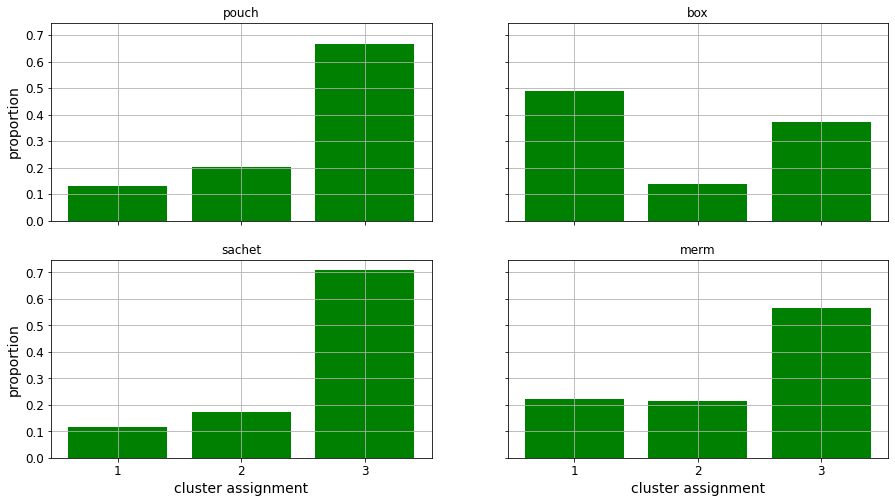

In [8]:
prototypes = np.reshape(config.model_config.prototypes,(2,2))
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        # Get the count table
        count_df= data[config.model_config.proto_cluster[prototypes[i,j]]].value_counts(normalize=True)
        # Bar plot
        axes[i,j].bar(x=count_df.index,
                      height=count_df.values,
                      color='green')
        # subplot grid 
        axes[i,j].grid()
        # subplot title
        axes[i,j].set(title=prototypes[i,j])
        # subplot xticks
        axes[i,j].set_xticks([1,2,3])
        
        # Set common labels
        plt.setp(axes[-1, :], xlabel='cluster assignment')
        plt.setp(axes[:, 0], ylabel='proportion')

**Comments: Clusters are pretty imabalanced for all prototypes. For the exception of boxes, there seems to be a dominent cluster for all prototypes.**

## Data processing
- Get processed data for the feature preference variables for each prototype: handle missing values, and perform type casting

In [9]:
# processed is a dictionary of dataframes
processed_dict = {p: pp.process_prototype_preference(data,p) for p in config.model_config.prototypes}

## Train test split
- Split data into train and test data for model evaluation (estimated test metric)

In [10]:
train_test_dict = {p:pp.test_harness(processed_dict,p) for p in config.model_config.prototypes} 

# Pouch

## Model training
- Train decision tree to aid in the interpretation of clusters
- Tune hyperparameters of decision tree using GridSearchCV
- Assess the optimized model with test data.

**Parameters for GridSearchCV**
- criterion: performance metrics
- max_depth: The max number of splits of the tree. The more splits I have, the more variance (but less bias) the tree has.
- max_feature: The max number of features that the tree would consider at each split.
- min_samples_split: The min number of samples reequired to split an internal node
- min_samples_left: The min number of samples required to be at a left node

In [11]:
# define parameters search grid
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,10),
    'max_features': range(1,5)
}

In [12]:
config.model_config.pouch_dt_params["min_samples_leaf"]

1

In [13]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state=config.model_config.random_state,
                    min_samples_leaf = config.model_config.pouch_dt_params["min_samples_leaf"], # inc for a more general model
                    ccp_alpha = config.model_config.pouch_dt_params["pruning_level"]), # increase for a more general model 
                           param_grid = param_grid,
                           scoring = 'f1_micro',
                           cv = 20, 
                           n_jobs = -1,  # n_jobs = -1 means use all processors
                           verbose = 1) # show the process

In [14]:
# Fit the grid search to the data
grid_search.fit(train_test_dict["pouch"]["X_train"], train_test_dict["pouch"]["y_train"])

Fitting 20 folds for each of 72 candidates, totalling 1440 fits


GridSearchCV(cv=20, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'max_features': range(1, 5)},
             scoring='f1_micro', verbose=1)

In [15]:
# Persist the model
save_file_name = f"pouch_clf_gs_model_{__version__}.pkl"
save_path = TRAINED_MODEL_DIR / save_file_name
joblib.dump(grid_search, save_path)

['/Users/hfung/Documents/PycharmProjects/sandbox/tb_adherence/outputs/trained_models/pouch_clf_gs_model_0.0.1.pkl']

In [16]:
print("The best parameters are: {}".format(grid_search.best_params_))
print("The best estimated test error (fron CV): {}".format(grid_search.best_score_))
best_tree_clf = grid_search.best_estimator_ # save the best tree clf

The best parameters are: {'criterion': 'gini', 'max_depth': 5, 'max_features': 4}
The best estimated test error (fron CV): 0.9888888888888889


In [17]:
# test predictions 
y_pred = grid_search.predict(train_test_dict["pouch"]["X_test"]) 

In [18]:
# Evaluate the model with grid_search_cv
print(f'''The test accuracy of the optimized decision tree on test data) is: 
{accuracy_score(train_test_dict["pouch"]["y_test"],y_pred)}''')
print()
print("Confusion Matrix")
print(classification_report(train_test_dict["pouch"]["y_test"],y_pred))

The test accuracy of the optimized decision tree on test data) is: 
1.0

Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        14

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Decision tree (prototype features preference)
- Find the most predictive features in tree
- Retrain tree with the most important features (if necessary)

In [19]:
feature_importance = pd.DataFrame({'feature': list(train_test_dict["pouch"]["X_train"].columns), 
                                 'importance': grid_search.best_estimator_.feature_importances_})

# Show the top 3 most important
feature_importance = feature_importance.sort_values('importance', ascending = False).reset_index(drop=True)

feature_importance.head(5)

,feature,importance
0,weight_comfort,0.487420
1,storage_capcity,0.302679
2,pouch_dailyTravel,0.064736
3,prescript_card,0.044624
4,storage_othmedic,0.036887


<Figure size 720x720 with 0 Axes>

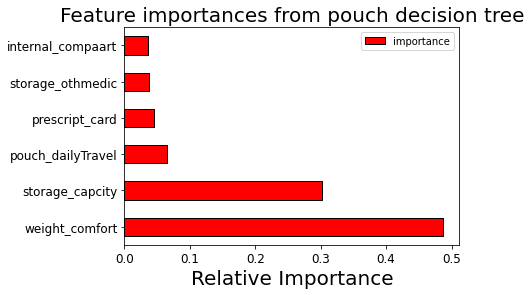

In [20]:
fig = plt.figure (figsize=(10,10))

# Plot the 10 most important features in a horizontal bar chart
feature_importance.loc[:5, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'red');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature importances from pouch decision tree', size = 20);

save_file_name = f"pouch_feature_importance.png"
save_path = IMAGES_DIR / save_file_name
plt.savefig(save_path)

plt.show()

## Pouch: Decision Tree Visualization
- **Path**: the left path is always TRUE, and right path is FALSE (e.g., weight_comfort <=0.5, in our case, since all our features are binary, that means the left branch is weight_comfort = 0, and right branch is weight_comfort = 1)
- **Gini score**: is a metric that quantifies the purity of the node/leaf (more about leaves in a bit). A gini score greater than zero implies that samples contained within that node belong to different classes. A gini score of zero means that the node is pure, that within that node only a single class of samples exist.
- **Sample**: number of observations in each node. We start off X (sample = X of the highest node) observations because we have X observations in our train set.
- **value**: a list that tells you how many samples at the given node fall into each category. The first element of the list shows the number of samples that belong to class 1, and the second number class 2 etc...
- **class**: class shows the prediction a given node will make and it can be determined from the value list. Whichever class occurs the most within the node will be selected as the class value.

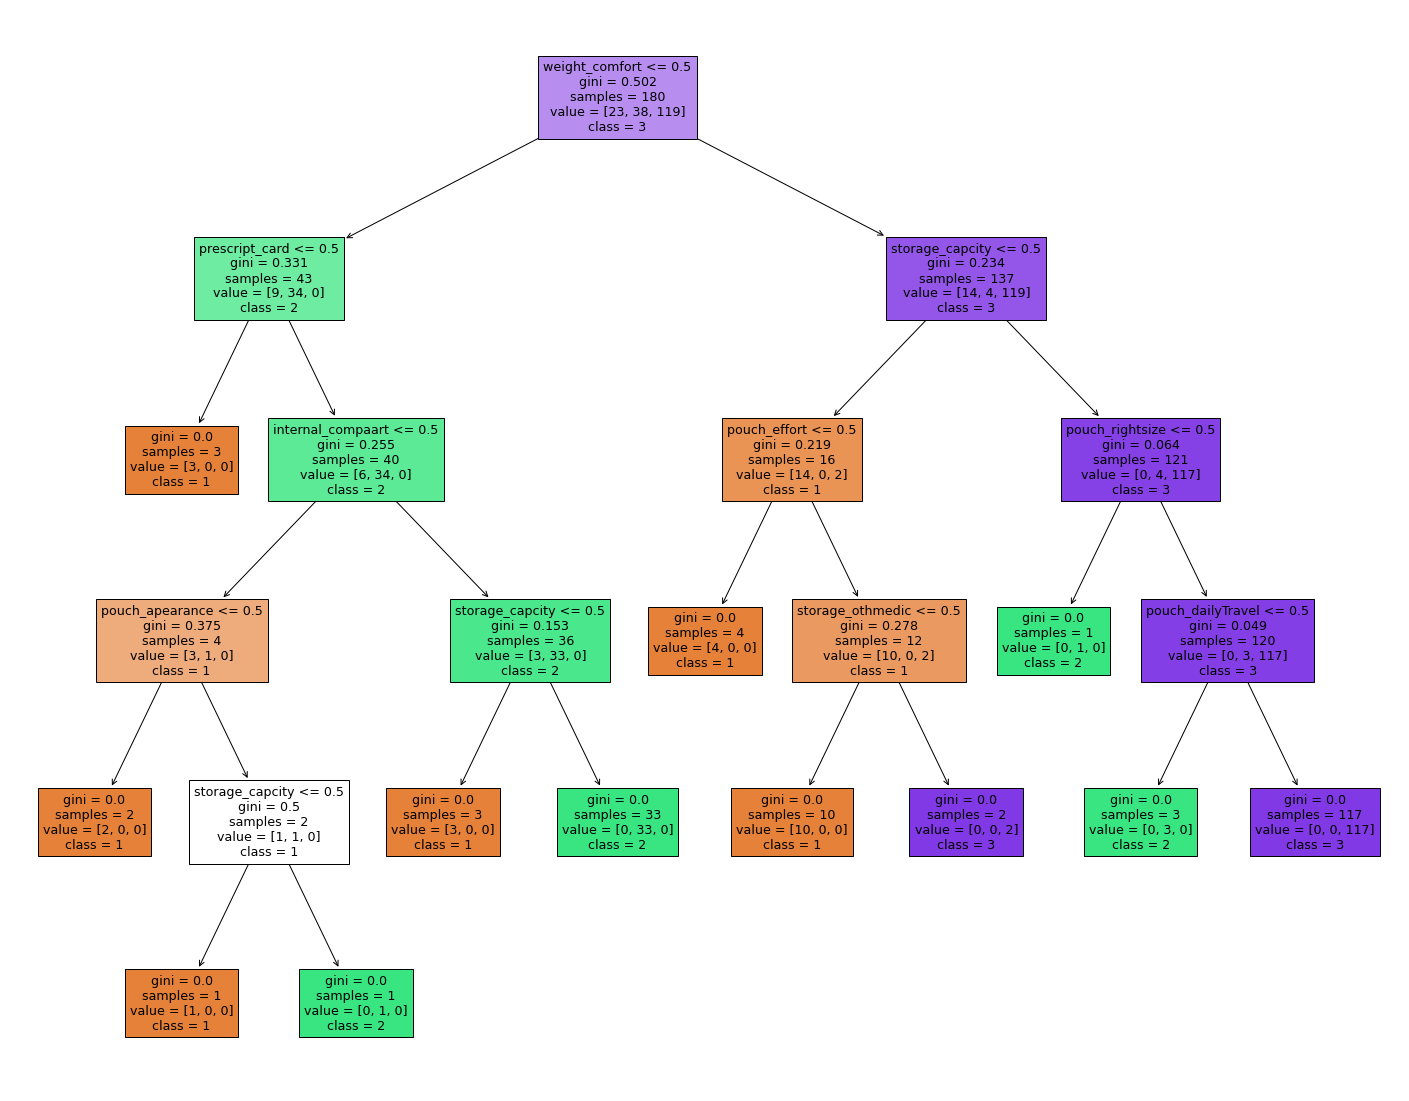

In [21]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(best_tree_clf, 
                   feature_names=train_test_dict["pouch"]["X_train"].columns.values,  
                   class_names= ['1','2','3'],
                   filled=True)


save_file_name = "pouch_decision_tree.pdf"
save_path = IMAGES_DIR / save_file_name
plt.savefig(save_path)

plt.show()

### Automating the rule interpretation of each class
- To get a more general rule, we could increase the value of min_samples_leaf or pruning_level (increase cost of adding one more node to tree). 
- Otherwise, if we want to get a more detail rule, we could decrease the value of min_samples_leaf or pruning_level.

In [22]:
cr.cluster_report(train_test_dict["pouch"]["X_train"],
                  train_test_dict["pouch"]["y_train"],
                  min_samples_leaf = config.model_config.pouch_dt_params["min_samples_leaf"],
                  pruning_level = config.model_config.pouch_dt_params["pruning_level"]) # ccp_alpha

,class_name,instance_count,rule_list
2,1,23,[1.0] (weight_comfort <= 0.5) and (storage_capcity <= 0.5)[1.0] (weight_comfort > 0.5) and (storage_othmedic <= 0.5) and (storage_capcity <= 0.5)
1,2,38,[1.0] (weight_comfort <= 0.5) and (storage_capcity > 0.5)[1.0] (weight_comfort > 0.5) and (storage_othmedic <= 0.5) and (storage_capcity > 0.5) and (pouch_dailyTravel <= 0.5)[1.0] (weight_comfort > 0.5) and (storage_othmedic > 0.5) and (pouch_dailyTravel <= 0.5)[1.0] (weight_comfort > 0.5) and (storage_othmedic > 0.5) and (pouch_dailyTravel > 0.5) and (pouch_rightsize <= 0.5)
0,3,119,[1.0] (weight_comfort > 0.5) and (storage_othmedic <= 0.5) and (storage_capcity > 0.5) and (pouch_dailyTravel > 0.5)[1.0] (weight_comfort > 0.5) and (storage_othmedic > 0.5) and (pouch_dailyTravel > 0.5) and (pouch_rightsize > 0.5)


## Interpretation of Pouch Clusters

- **Cluster 1:**
    - Thinks pouch have comfortable weight
    - Doesn't like storage capacity
    - Thinks pouch is easy to open/close
    - Doesn't think pouch can store other mediciations
- **Interpretation: Mixed Group likes pouch weight, but doesn't like its storage capacity**
<br><br>
- **Cluster 2:**
    - Thinks pouch does not have comfortable weight
    - Thinks the prescription card and internal compartment is useful
    - Rates pouch highly on storage capacity of 4 blister packages
- **Interpretation: Mixed Group: doesn't like pouch weight but like it's storage capacity, and other features like internal compartment and prescription card**
<br><br>
- **Cluster 3:** 
    - Thinks pouch has a comfortable weight
    - Thinks pouch has the right size
    - Thinks it is easy to carry pouch for daily travel
- **Interpretation: Positive group: likes pouch weight, storage capacity and portability**

######################################################################################################################

# Box

In [23]:
# define parameters search grid
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,10),
    'max_features': range(1,5)
}

In [24]:
box_gs = tr.gs_fit(train_test_dict=train_test_dict,
                     p="box",
                     param_grid = param_grid,
                     scoring = 'f1_micro',
                     cv=20,
                     min_samples_leaf = config.model_config.box_dt_params["min_samples_leaf"], # default is 1
                     pruning_level = config.model_config.box_dt_params["pruning_level"]) # default is 0 

Fitting 20 folds for each of 72 candidates, totalling 1440 fits
*********The model has succesfully been fitted! *********


The tuned hyperparameters for the model are: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4}
The best estimated test accuracy (fron CV): 0.9270833333333333


The test accuracy score of the optimized decision tree on test data) is: 
    0.85

Classification Report (on test data)
              precision    recall  f1-score   support

           1       1.00      0.88      0.93         8
           2       0.50      0.67      0.57         3
           3       0.89      0.89      0.89         9

    accuracy                           0.85        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.88      0.85      0.86        20



<Figure size 720x720 with 0 Axes>

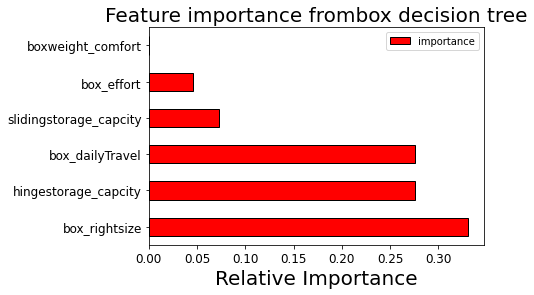

In [25]:
ev.evaluate(gs=box_gs,
           train_test_dict = train_test_dict,
           p = 'box')

## Box: Decision Tree Visualization

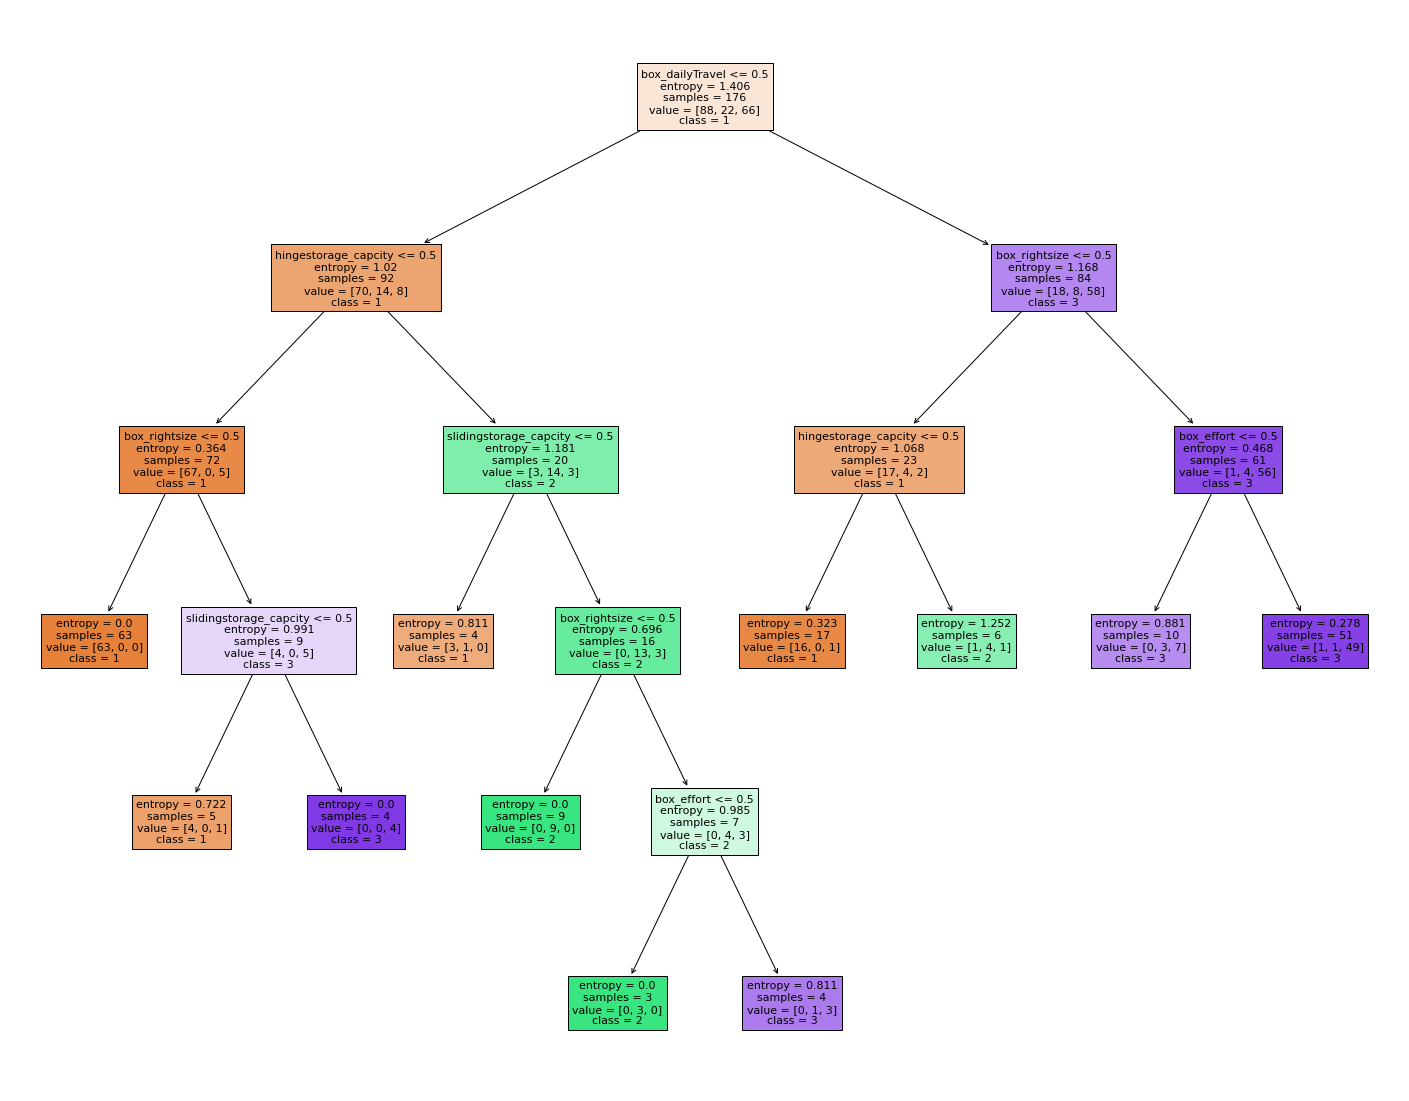

In [26]:
p="box"
clf = box_gs

fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf.best_estimator_, 
                   feature_names=train_test_dict[p]["X_train"].columns.values,  
                   class_names= ['1','2','3'],
                   filled=True)

save_file_name = f"{p}_decision_tree.pdf"
save_path = IMAGES_DIR / save_file_name
plt.savefig(save_path)

plt.show()

### Automating the rule interpretation of each class
- To get a more general rule, we could increase the value of min_samples_leaf or pruning_level (increase cost of adding one more node to tree). 
- Otherwise, if we want to get a more detail rule, we could decrease the value of min_samples_leaf or pruning_level.

In [27]:
cr.cluster_report(train_test_dict[p]["X_train"],
                  train_test_dict[p]["y_train"],
                  min_samples_leaf = config.model_config.box_dt_params["min_samples_leaf"],
                  pruning_level = config.model_config.box_dt_params["pruning_level"]) # ccp_alpha

,class_name,instance_count,rule_list
0,1,88,[0.9875] (box_rightsize <= 0.5) and (hingestorage_capcity <= 0.5)[0.8] (box_rightsize <= 0.5) and (hingestorage_capcity > 0.5) and (slidingstorage_capcity <= 0.5)[1.0] (box_rightsize > 0.5) and (boxcomfrt_publ <= 0.5) and (box_dailyTravel <= 0.5) and (hingestorage_capcity <= 0.5)
2,2,22,[1.0] (box_rightsize <= 0.5) and (hingestorage_capcity > 0.5) and (slidingstorage_capcity > 0.5)[1.0] (box_rightsize > 0.5) and (boxcomfrt_publ <= 0.5) and (box_dailyTravel <= 0.5) and (hingestorage_capcity > 0.5)
1,3,66,[0.6923076923076923] (box_rightsize > 0.5) and (boxcomfrt_publ <= 0.5) and (box_dailyTravel > 0.5)[0.9821428571428571] (box_rightsize > 0.5) and (boxcomfrt_publ > 0.5)


## Interpretation of Box Clusters

- **Cluster 1:**
  - Thinks that the box is not easy to carry around during daily travel
  - Doesn't rate the hinge storage capacity of boxes.
  - Doesn't think the box has the right size.
- **Interpretation: Negative group: have issues with size, portability and hinge storage**
<br><br>
- **Cluster 2:**
    - Thinks that the box is not easy to carry around during daily travel
    - Rates highly the hinge and sliding storage of boxes
    - Mix feelings about size of boxes
- **Interpretation: Mixed group: Have issue with portability and size, but likes hinge and sliding storage**
<br><br>
- **Cluster 3:** 
    - Thinks that the box is easy to carry around during daily travel
    - Thinks box has the right size
    - Thinks box is easy to open (no effort needed)
- **Interpretation: Positive group: Likes size, portability and acccess of box

######################################################################################################################

# Sachet

In [28]:
# define parameters search grid
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,10),
    'max_features': range(1,5)
}

In [29]:
sachet_gs = tr.gs_fit(train_test_dict=train_test_dict,
                     p="sachet",
                     param_grid = param_grid,
                     scoring = 'f1_micro',
                     cv=20,
                     min_samples_leaf = config.model_config.sachet_dt_params["min_samples_leaf"], # default is 1
                     pruning_level = config.model_config.sachet_dt_params["pruning_level"]) # default is 0 

Fitting 20 folds for each of 72 candidates, totalling 1440 fits
*********The model has succesfully been fitted! *********


The tuned hyperparameters for the model are: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4}
The best estimated test accuracy (fron CV): 1.0


The test accuracy score of the optimized decision tree on test data) is: 
    1.0

Classification Report (on test data)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        16

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<Figure size 720x720 with 0 Axes>

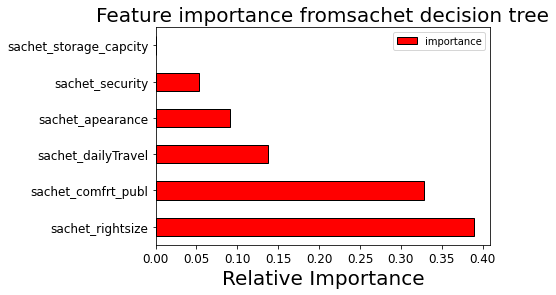

In [30]:
ev.evaluate(gs=sachet_gs,
           train_test_dict = train_test_dict,
           p = 'sachet')

## Sachet: Decision Tree Visualization

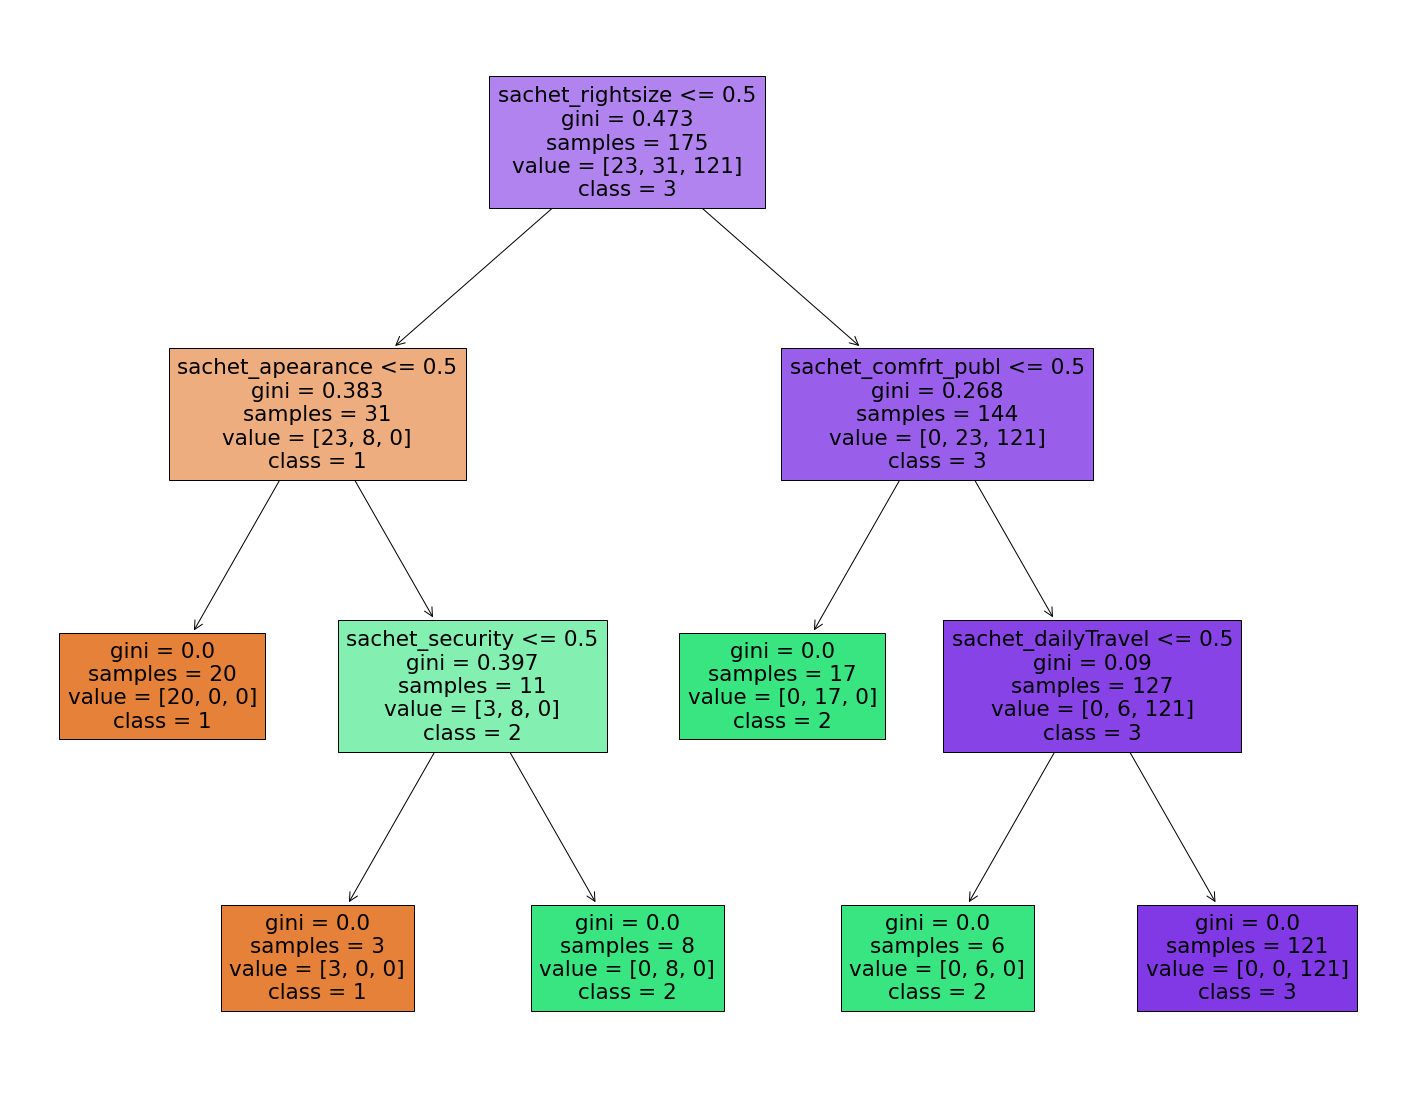

In [31]:
p = "sachet"
clf = sachet_gs


fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf.best_estimator_, 
               feature_names=train_test_dict[p]["X_train"].columns.values,  
               class_names= ['1','2','3'],
               filled=True)

save_file_name = f"{p}_decision_tree.pdf"
save_path = IMAGES_DIR / save_file_name
plt.savefig(save_path)

plt.show()

### Automating the rule interpretation of each class
- To get a more general rule, we could increase the value of min_samples_leaf or pruning_level (increase cost of adding one more node to tree). 
- Otherwise, if we want to get a more detail rule, we could decrease the value of min_samples_leaf or pruning_level.

In [32]:
cr.cluster_report(train_test_dict[p]["X_train"],
                  train_test_dict[p]["y_train"],
                  min_samples_leaf = config.model_config.sachet_dt_params["min_samples_leaf"],
                  pruning_level = config.model_config.sachet_dt_params["pruning_level"]) # ccp_alpha

,class_name,instance_count,rule_list
2,1,23,[1.0] (sachet_rightsize <= 0.5) and (sachet_apearance <= 0.5)[1.0] (sachet_rightsize <= 0.5) and (sachet_apearance > 0.5) and (sachet_security <= 0.5)
1,2,31,[1.0] (sachet_rightsize <= 0.5) and (sachet_apearance > 0.5) and (sachet_security > 0.5)[1.0] (sachet_rightsize > 0.5) and (sachet_comfrt_publ <= 0.5)[1.0] (sachet_rightsize > 0.5) and (sachet_comfrt_publ > 0.5) and (sachet_dailyTravel <= 0.5)
0,3,121,[1.0] (sachet_rightsize > 0.5) and (sachet_comfrt_publ > 0.5) and (sachet_dailyTravel > 0.5)


## Interpretation of Sachet Clusters

- **Cluster 1:**
  - Do not think sachet has the right size
  - Do not like the look and feel of sachet
- **Interpretation: Negative group: do not like the size and appearance of sachet.**
<br><br>
- **Cluster 2:**
    - Most feel that sachet has the right size, but are not comfortable using it in public
    - A small proportion in this group has no stigma but does not feel sachet is easy to carry around
- **Interpretation: Mixed group: have issues with stigma and portability.**
<br><br>
- **Cluster 3:** 
    - Thinks that sachet has the right size
    - Comfortable in using sachet in public
    - Thinks MERM is easy to carry for daily travel
- **Interpretation: Very positive group: no stigma and likes size and portability of MERM

######################################################################################################################

# MERM

In [33]:
# define parameters search grid
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,10),
    'max_features': range(1,5)
}

In [34]:
merm_gs = tr.gs_fit(train_test_dict=train_test_dict,
                     p="merm",
                     param_grid = param_grid,
                     scoring = 'f1_micro',
                     cv=20,
                     min_samples_leaf = config.model_config.merm_dt_params["min_samples_leaf"], # default is 1
                     pruning_level = config.model_config.merm_dt_params["pruning_level"]) # default is 0 

Fitting 20 folds for each of 72 candidates, totalling 1440 fits
*********The model has succesfully been fitted! *********


The tuned hyperparameters for the model are: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4}
The best estimated test accuracy (fron CV): 0.9270833333333334


The test accuracy score of the optimized decision tree on test data) is: 
    0.9

Classification Report (on test data)
              precision    recall  f1-score   support

           1       0.80      0.80      0.80         5
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         9

    accuracy                           0.90        20
   macro avg       0.88      0.88      0.88        20
weighted avg       0.90      0.90      0.90        20



<Figure size 720x720 with 0 Axes>

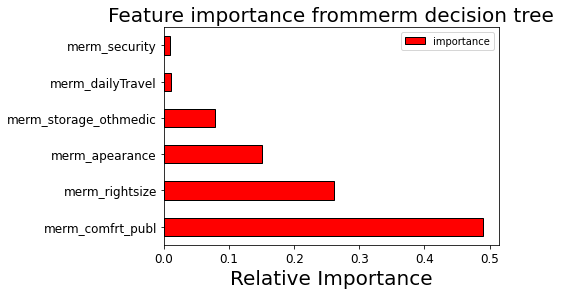

In [35]:
ev.evaluate(gs=merm_gs,
           train_test_dict = train_test_dict,
           p = 'merm')

## MERM: Decision Tree Visualization

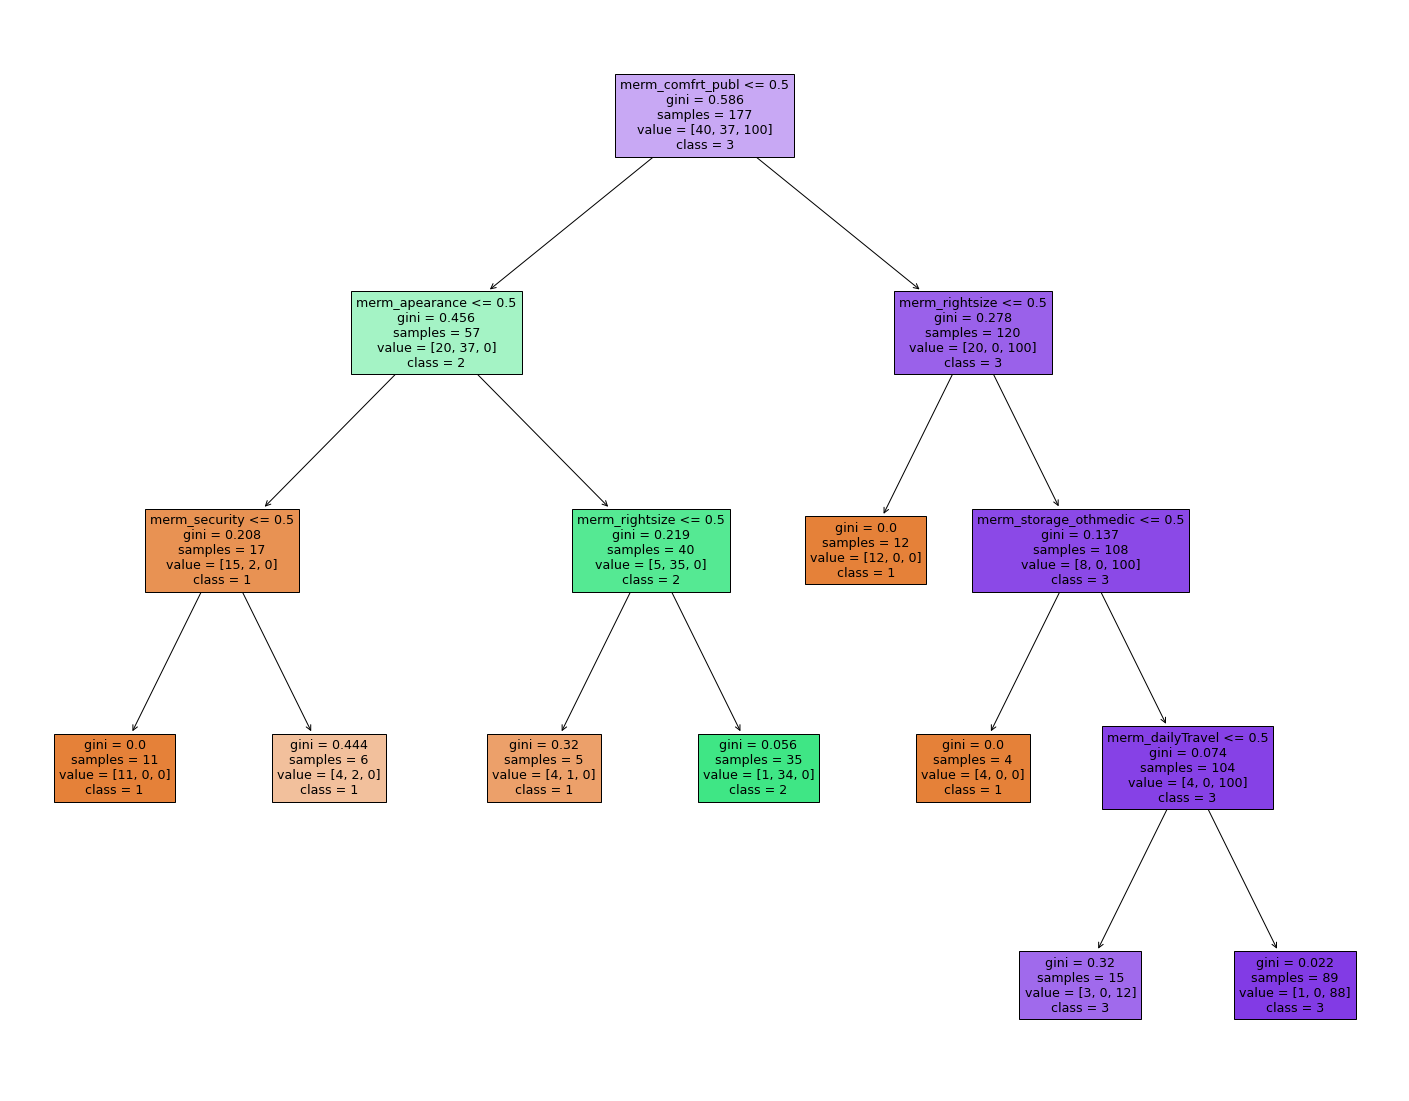

In [36]:
p = "merm"
clf = merm_gs


fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf.best_estimator_, 
               feature_names=train_test_dict[p]["X_train"].columns.values,  
               class_names= ['1','2','3'],
               filled=True)

save_file_name = f"{p}_decision_tree.pdf"
save_path = IMAGES_DIR / save_file_name
plt.savefig(save_path)

plt.show()

### Automating the rule interpretation of each class
- To get a more general rule, we could increase the value of min_samples_leaf or pruning_level (increase cost of adding one more node to tree). 
- Otherwise, if we want to get a more detail rule, we could decrease the value of min_samples_leaf or pruning_level.

In [37]:
cr.cluster_report(train_test_dict[p]["X_train"],
                  train_test_dict[p]["y_train"],
                  min_samples_leaf = config.model_config.merm_dt_params["min_samples_leaf"],
                  pruning_level = config.model_config.merm_dt_params["pruning_level"]) # ccp_alpha

,class_name,instance_count,rule_list
1,1,40,[1.0] (merm_comfrt_publ <= 0.5) and (merm_rightsize <= 0.5) and (merm_apearance <= 0.5)[0.8] (merm_comfrt_publ <= 0.5) and (merm_rightsize <= 0.5) and (merm_apearance > 0.5)[0.75] (merm_comfrt_publ <= 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic <= 0.5)[1.0] (merm_comfrt_publ > 0.5) and (merm_rightsize <= 0.5)[1.0] (merm_comfrt_publ > 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic <= 0.5)
2,2,37,[0.75] (merm_comfrt_publ <= 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_dailyTravel <= 0.5) and (merm_weight_comfort <= 0.5)[1.0] (merm_comfrt_publ <= 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_dailyTravel <= 0.5) and (merm_weight_comfort > 0.5)[1.0] (merm_comfrt_publ <= 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_dailyTravel > 0.5)
0,3,100,[0.625] (merm_comfrt_publ > 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_security <= 0.5)[0.75] (merm_comfrt_publ > 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_security > 0.5) and (merm_dailyTravel <= 0.5) and (merm_weight_comfort <= 0.5)[1.0] (merm_comfrt_publ > 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_security > 0.5) and (merm_dailyTravel <= 0.5) and (merm_weight_comfort > 0.5)[1.0] (merm_comfrt_publ > 0.5) and (merm_rightsize > 0.5) and (merm_storage_othmedic > 0.5) and (merm_security > 0.5) and (merm_dailyTravel > 0.5)


## Interpretation of MERM Clusters

- **Cluster 1:**
  - Half mind using MERM in public, the other half does not mind.
  - Those how don't mind using MERM in public do not think MERM has the right size
  - Those who mind using MERM in public also do not think MERM has the right size and thinks MERM cannot store medication in a secure way
- **Interpretation: Negative group: some have issues with stigma, most have issue with size and storage security.**
<br><br>
- **Cluster 2:**
    - Not comfortable using MERM in public
    - Thinks MERM has the right size
- **Interpretation: Mixed group: Affected by stigma but like size of MERM**
<br><br>
- **Cluster 3:** 
    - Comfortable in using the MERM in public
    - Thinks MERM has the right size
    - Thinks MERM can store other medications
    - Thinks MERM is easy to carry for daily travel
- **Interpretation: Positive group: no stigma and likes function, size and portability of MERM